# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


In [1]:
import tensorflow as tf
import numpy as np
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import cv2 as cv2
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.contrib.layers import flatten
# Visualizations will be shown in the notebook.
%matplotlib inline
sns.set_style("white")

/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './train.p'
validation_file = './valid.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of validation examples
n_validation = len(y_valid)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (34799, 32, 32, 3)
Number of classes = 43


# Visualize dataset
I implemented two functions, show_random() and show_class().  
By looking at 20 samples from class No.0, I can assume that the data set  
is diverse in terms of color, brighteness and zoom, but may lack diversity  
in terms of position. I may have to add augmented samples if that causes problem.

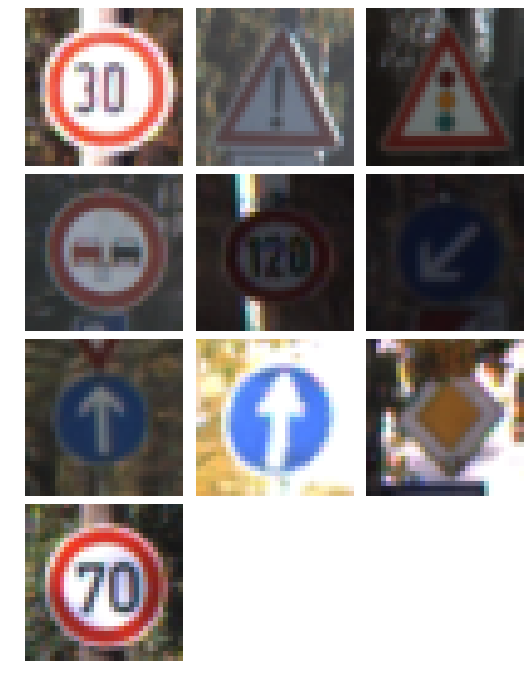

In [4]:
# show random image from train set
def show_random(x, num=1, col=3):   
    '''
    x: (None, width, height, channel) numpy array
    '''
    plt.figure(figsize=(col**2, col*int(np.ceil(num/col))))
    gs1 = gridspec.GridSpec(int(np.ceil(num/col)), col)
    gs1.update(wspace=0.05, hspace=0.05)
    for i in range(num):
        img = x[np.random.randint(0, x.shape[0], 1)].squeeze()
        plt.subplot(gs1[int(i)])
        plt.axis('off')        
        plt.imshow(img)
show_random(X_train, 10)

# Observation
30 samples from training set. We can see various augmentations have already been applied.

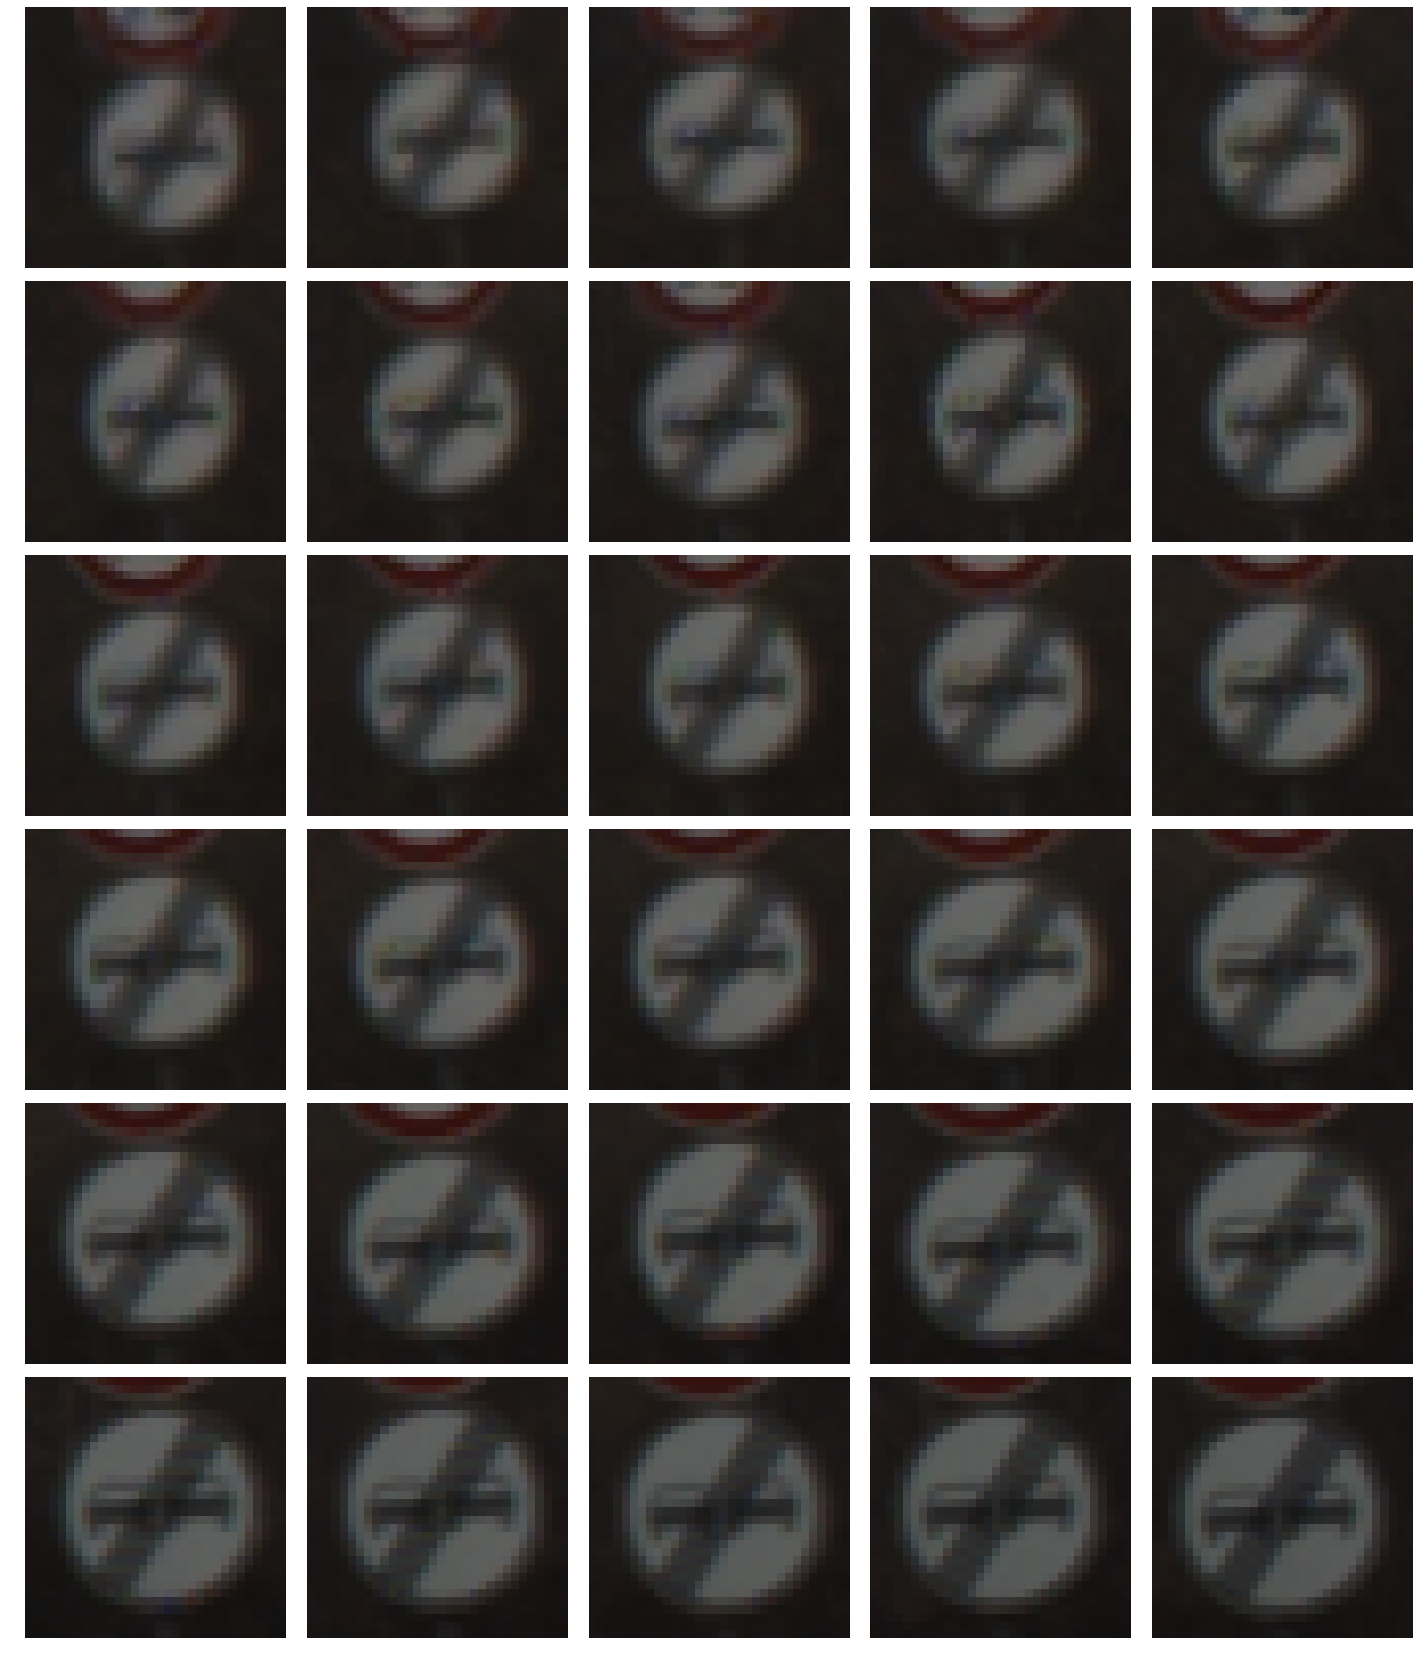

In [5]:
def show_all(x, col=5):
    num = x.shape[0]
    plt.figure(figsize=(col**2, col*int(np.ceil(num/col))))
    gs1 = gridspec.GridSpec(int(np.ceil(num/col)), col)
    gs1.update(wspace=0.05, hspace=0.05)
    for i in range(num):        
        img = x[i].squeeze()
        plt.subplot(gs1[int(i)])
        plt.axis('off')        
        plt.imshow(img)
show_all(X_train[:30])

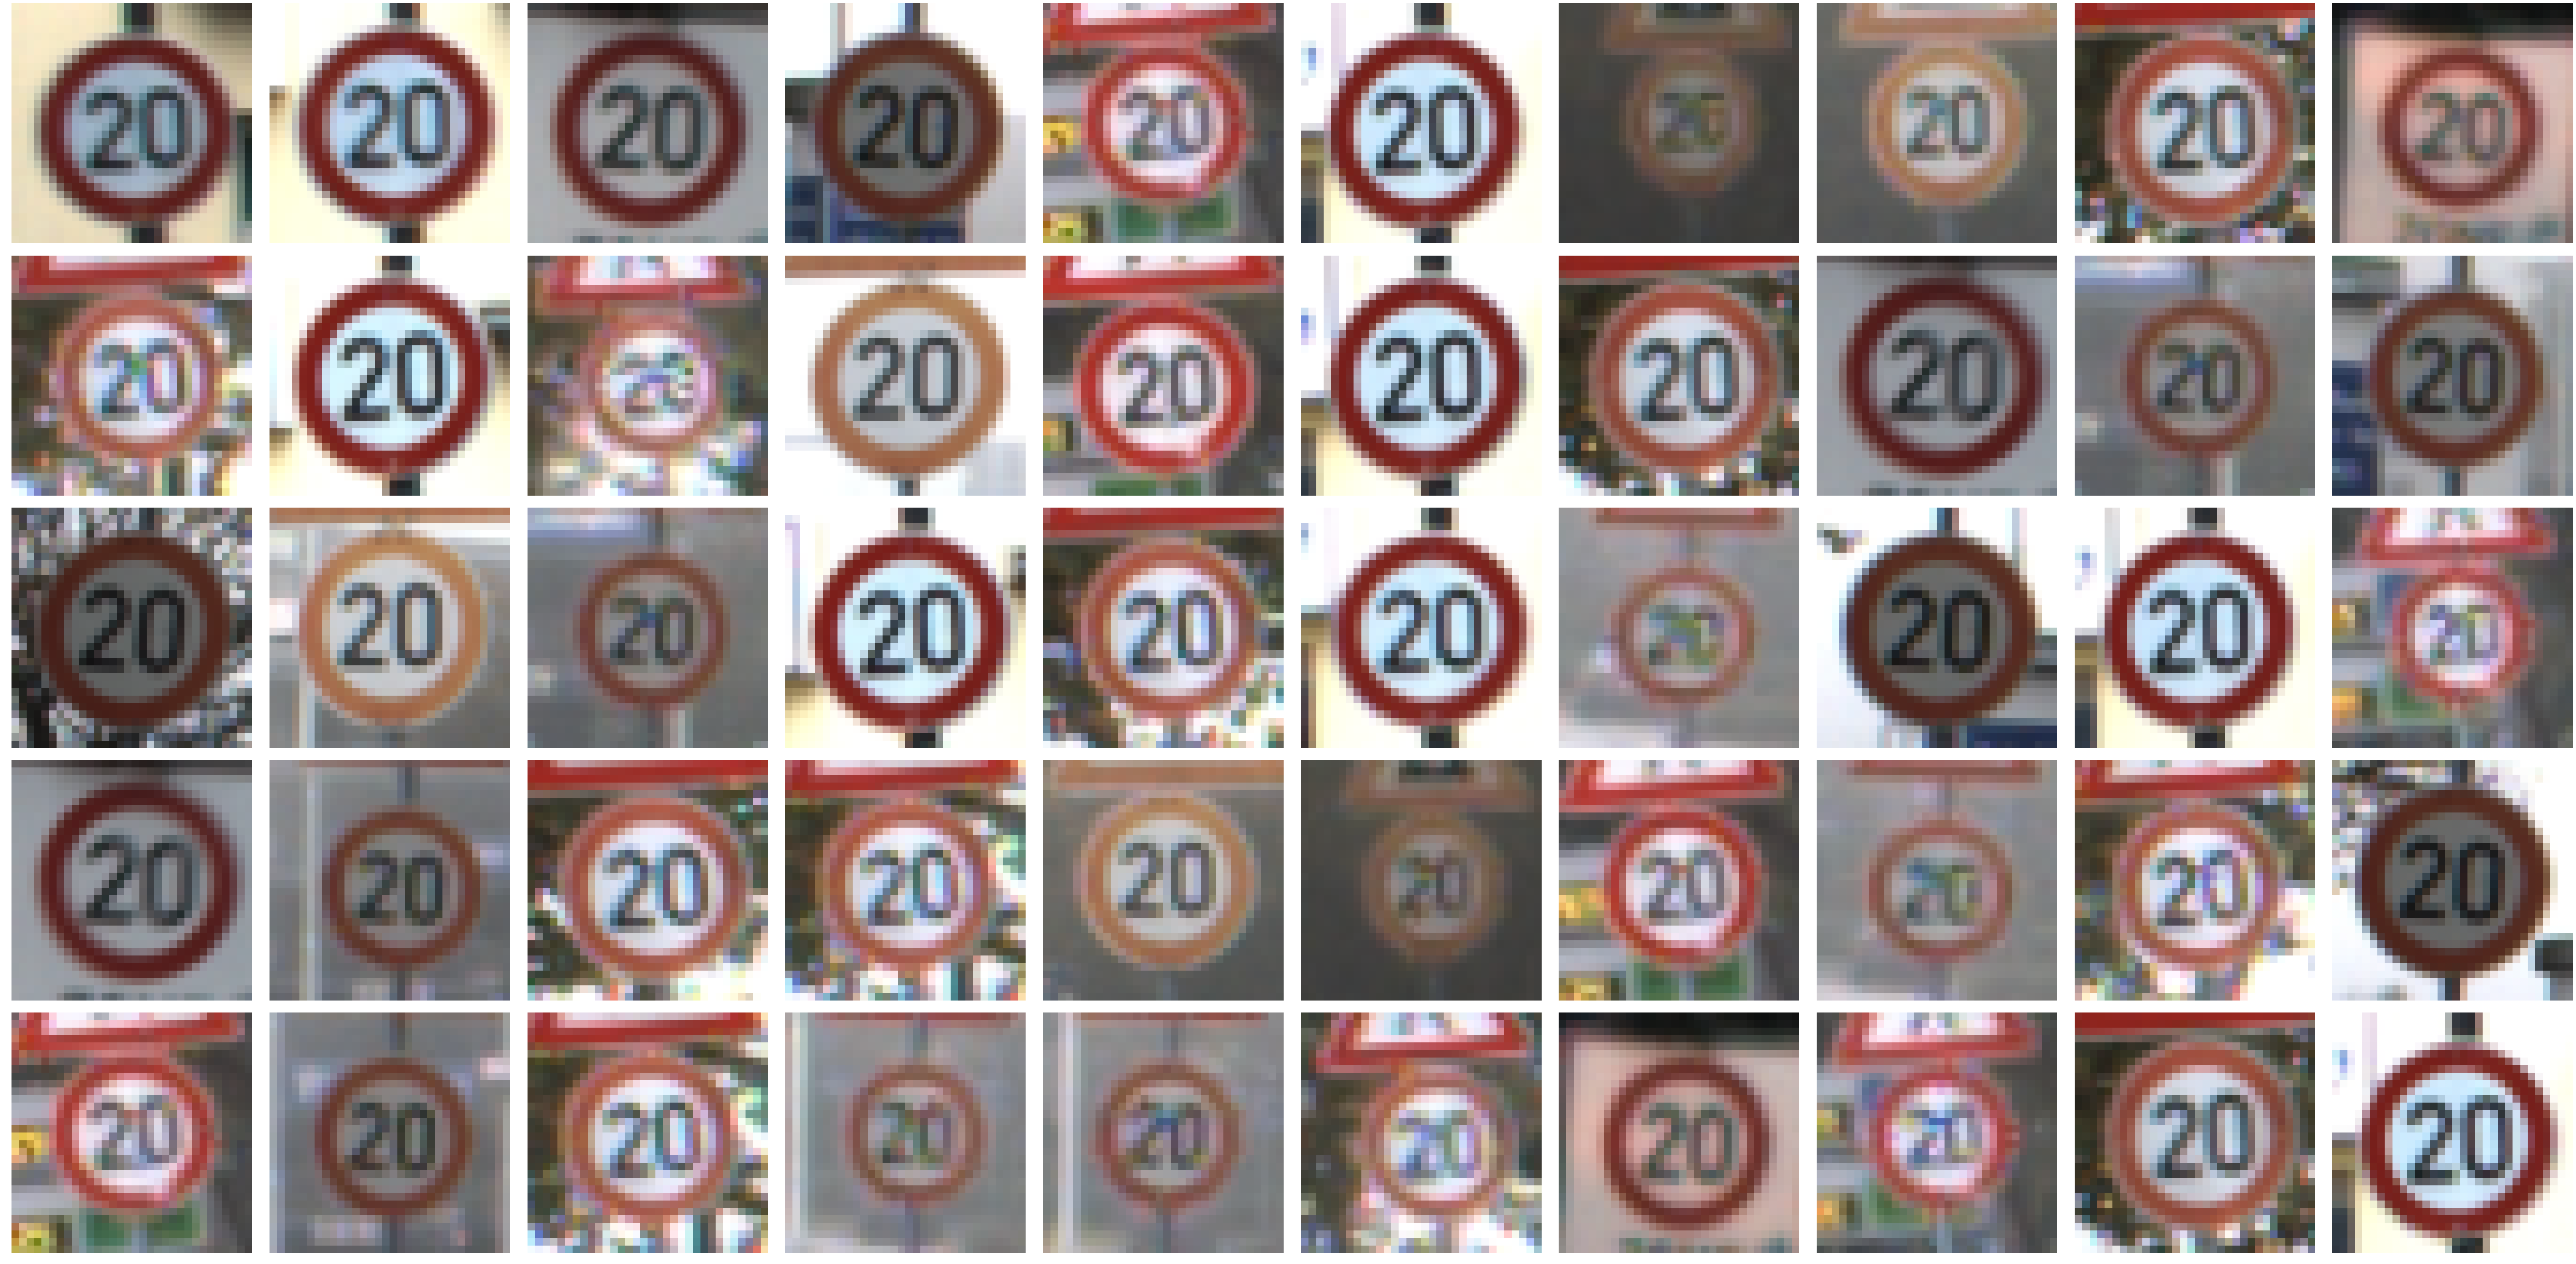

In [6]:
# show samples from certain class
def show_class(x, y, index, num=5):
    '''
    index: class index
    num: number of samples to display
    '''
    grp = x[y==index]
    show_random(grp, num, col=10)
show_class(X_train, y_train, 0, 50)

# Data distribution
The data set is skewed, and three data set seems to follow similar distribution pattern.  

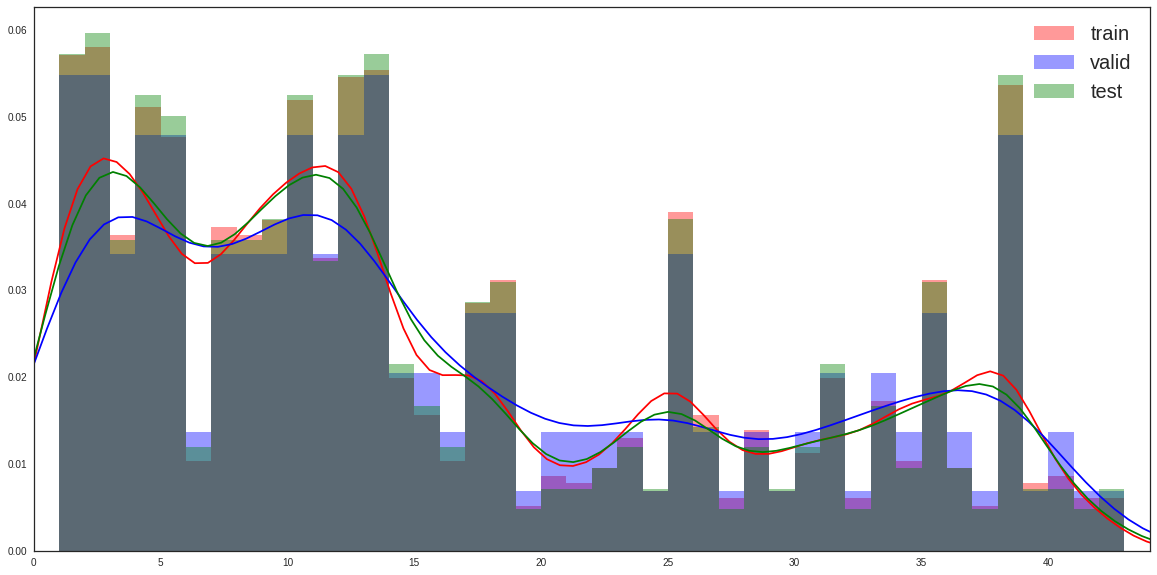

In [7]:
# class distribution of training, validation, test sets
fig, ax = plt.subplots(figsize=(20,10))
bins = np.arange(1,44)
sns.distplot(y_train, color='r', ax=ax, bins= bins, label='train')
sns.distplot(y_valid, color='b', ax=ax, bins= bins, label='valid')
sns.distplot(y_test, color='g', ax=ax, bins= bins, label='test')
plt.xlim((0,44))
plt.legend(fontsize=20)

In [8]:
# class ordering. The data set have to be shuffled.
print(y_train[:100])

[41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41]


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

I wrote proprocess() which normalizes dataset, and can do optional flags to apply histogram equalization, adaptive histogram equalization, image threshold.

In [9]:
def preprocess(imageset, gray=True, equal=False, thresh=False, adaeq=False):
    '''
    imageset is numpy array (N, width, height, 3)
    1) apply grayscale 
    2) normalize
    '''
    result = []
    for img in imageset:
        cvimg = img.astype(np.uint8)
        if gray:
            cvimg = cv2.cvtColor(cvimg, cv2.COLOR_RGB2GRAY)
        if equal:
            cv2.equalizeHist(cvimg, cvimg)
        if adaeq:
            # create a CLAHE object (Arguments are optional).
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
            cvimg = clahe.apply(cvimg)
        if thresh:       
            cvimg = cv2.adaptiveThreshold(cvimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \
                                          cv2.THRESH_BINARY,11,2)
        cv2.normalize(cvimg, cvimg, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        result.append(cvimg)
    result = np.array(result)
    result = result[..., None]
    return result

In [10]:
def get_random_image(imageset, num=5):
    ix = np.random.choice(imageset.shape[0], 5, replace=False)
    result = []
    for i, index in enumerate(ix):
        result.append(imageset[index])
    result = np.array(result)
    return result

# compare preprocessing options

I compared preprocessing options. The network worked best when I applied grayscale and  
adaptive histogram equalization on preliminary test, thus I used the setting from here on.

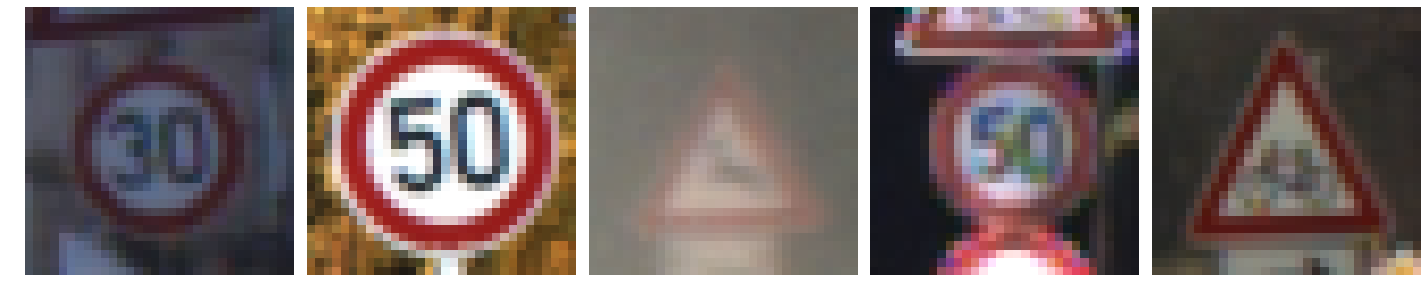

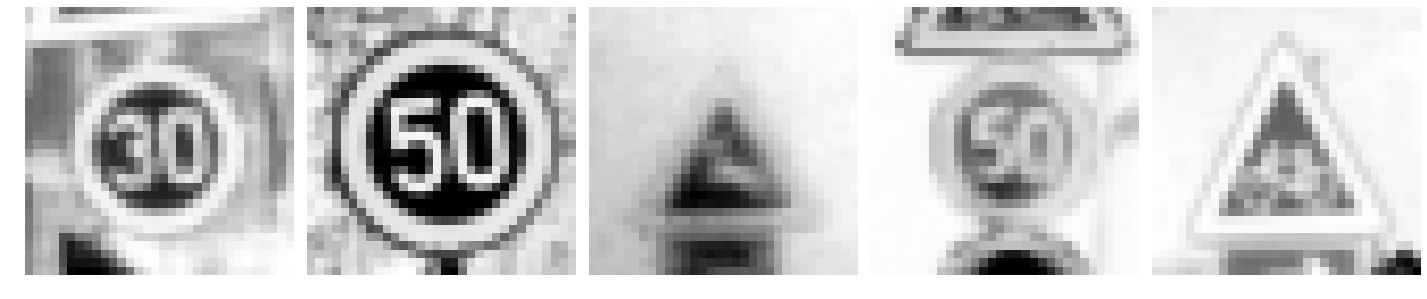

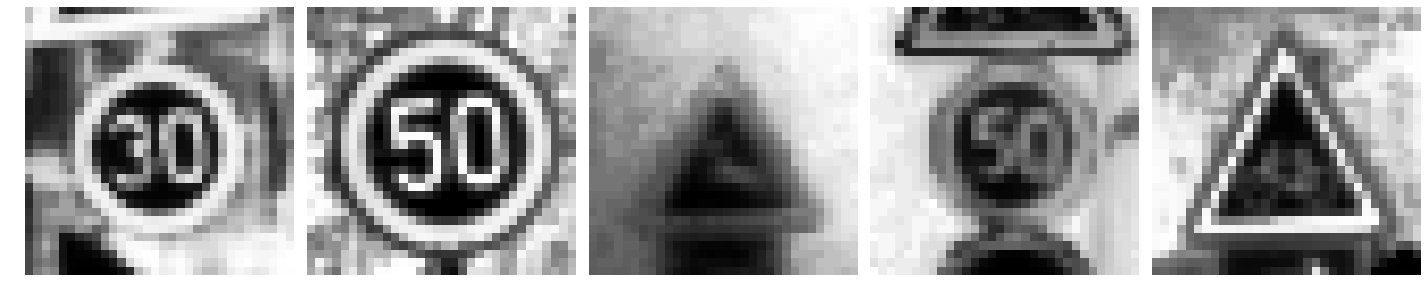

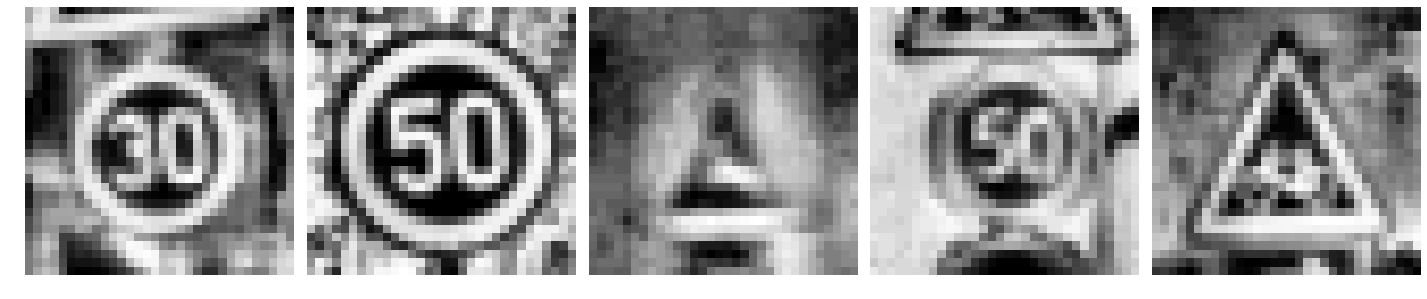

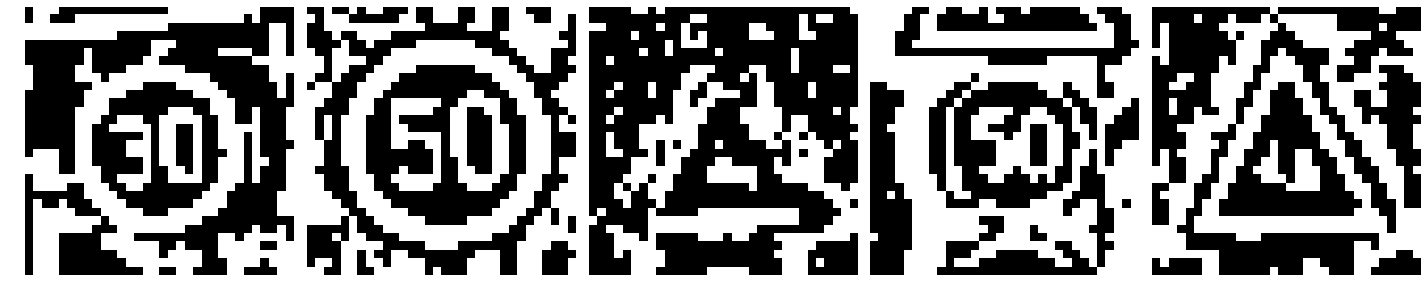

In [10]:
imageset = get_random_image(X_train, 5)
show_all(imageset)
show_all(preprocess(imageset, gray=True))
show_all(preprocess(imageset, gray=True, equal=True))
show_all(preprocess(imageset, gray=True, adaeq=True))
show_all(preprocess(imageset, gray=True, thresh=True))

# Model Architecture
## Modified Lenet
I tried various modifications.
1. Smaller kernel size: Did not change much, with much longer training time.  
2. Larger network (doubled the number of nodes): Training cost exceeded the level I can afford.
3. Dropout: As there were strong indication of overfitting with vanilla configuration, I added three dropout layers with keep probability of 0.5.


In [13]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
def LeNet(x, keep_prob, mu=0, sigma=.1):
    '''
    params: Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    '''  
    # TODO: Layer 1: Convolutional. Input = 32x32xchannel. Output = 28x28x6.
    conv1_w = tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, strides=[1,1,1,1], padding='VALID') + conv1_b
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')   
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2_w = tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1,1,1,1], padding='VALID') + conv2_b
    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    
    # add dropout
    fc0 = tf.nn.dropout(fc0, keep_prob)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_w = tf.Variable(tf.truncated_normal(shape=(400,120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_w) + fc1_b
    
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)
    
    # add drop out
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal(shape=(120,84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_w) + fc2_b
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)
    # add drop out
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [14]:
x = tf.placeholder(tf.float32, (None, 32,32,1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [15]:
logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [16]:
# batch size for evaluation
BATCH_SIZE = 128

In [17]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [18]:
def train_network(x_train, y_train, learning_rate=.001, epoch=5, batch_size=128, early_threshold=.0001, save=False, verbose=True):
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    training_operation = optimizer.minimize(loss_operation)    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(x_train)
        
        print("Training...")
        print()
        train_accuracy_log = []
        valid_accuracy_log = []
        last_accuracy = 0
        for i in range(epoch):
            x_train, y_train = shuffle(x_train, y_train)
            for offset in range(0, num_examples, batch_size):
                end = offset + batch_size
                batch_x, batch_y = x_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: .5})
            train_accuracy = evaluate(x_train, y_train)    
            validation_accuracy = evaluate(x_valid, y_valid)

            print("EPOCH {} ...".format(i+1))
            print("Training Accuracy={:.3f}".format(train_accuracy))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
            
            train_accuracy_log.append(train_accuracy)
            valid_accuracy_log.append(validation_accuracy)

            # early stop
            if abs(validation_accuracy - last_accuracy) < early_threshold:
                break
            last_accuracy = validation_accuracy
        
        if verbose:
            # print learning curve
            epochs = np.arange(1, epoch+1)
            plt.figure(figsize=(7, 7))
            plt.plot(epochs, train_accuracy_log, label='train')
            plt.plot(epochs, valid_accuracy_log, label='validation')
            plt.title('Learning Curve')
            plt.ylabel('accuracy')
            plt.xlabel('epochs')
            plt.xticks(epochs)
            plt.legend(loc='center right')
            
            # print per class accuracy
            pred = sess.run(tf.argmax(logits, 1), feed_dict={x: x_valid, keep_prob: 1.0})
            print(classification_report(y_valid, pred))
        
        if save:
            saver.save(sess, './lenet')
            print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy=0.078
Validation Accuracy = 0.065

EPOCH 2 ...
Training Accuracy=0.163
Validation Accuracy = 0.147

EPOCH 3 ...
Training Accuracy=0.226
Validation Accuracy = 0.196

EPOCH 4 ...
Training Accuracy=0.286
Validation Accuracy = 0.249

EPOCH 5 ...
Training Accuracy=0.319
Validation Accuracy = 0.297

EPOCH 6 ...
Training Accuracy=0.346
Validation Accuracy = 0.312

EPOCH 7 ...
Training Accuracy=0.409
Validation Accuracy = 0.380

EPOCH 8 ...
Training Accuracy=0.421
Validation Accuracy = 0.389

EPOCH 9 ...
Training Accuracy=0.453
Validation Accuracy = 0.425

EPOCH 10 ...
Training Accuracy=0.485
Validation Accuracy = 0.437

EPOCH 11 ...
Training Accuracy=0.512
Validation Accuracy = 0.470

EPOCH 12 ...
Training Accuracy=0.546
Validation Accuracy = 0.510

EPOCH 13 ...
Training Accuracy=0.581
Validation Accuracy = 0.539

EPOCH 14 ...
Training Accuracy=0.608
Validation Accuracy = 0.555

EPOCH 15 ...
Training Accuracy=0.620
Validation Accuracy = 0.573

EPOCH 

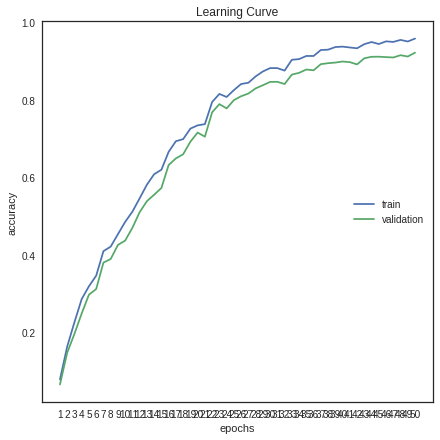

In [25]:
# more epoch, 3 drop out
x_train = preprocess(X_train, gray=True, adaeq=True)
x_valid = preprocess(X_valid, gray=True, adaeq=True)
x_test = preprocess(X_test, gray=True, adaeq=True)
train_network(x_train, y_train, epoch=50, learning_rate=.001, save=True)

Training...

EPOCH 1 ...
Training Accuracy=0.269
Validation Accuracy = 0.231

EPOCH 2 ...
Training Accuracy=0.589
Validation Accuracy = 0.539

EPOCH 3 ...
Training Accuracy=0.737
Validation Accuracy = 0.679

EPOCH 4 ...
Training Accuracy=0.813
Validation Accuracy = 0.750

EPOCH 5 ...
Training Accuracy=0.864
Validation Accuracy = 0.808

EPOCH 6 ...
Training Accuracy=0.893
Validation Accuracy = 0.834

EPOCH 7 ...
Training Accuracy=0.905
Validation Accuracy = 0.845

EPOCH 8 ...
Training Accuracy=0.929
Validation Accuracy = 0.882

EPOCH 9 ...
Training Accuracy=0.935
Validation Accuracy = 0.883

EPOCH 10 ...
Training Accuracy=0.949
Validation Accuracy = 0.896

EPOCH 11 ...
Training Accuracy=0.951
Validation Accuracy = 0.899

EPOCH 12 ...
Training Accuracy=0.951
Validation Accuracy = 0.898

EPOCH 13 ...
Training Accuracy=0.957
Validation Accuracy = 0.905

EPOCH 14 ...
Training Accuracy=0.969
Validation Accuracy = 0.921

EPOCH 15 ...
Training Accuracy=0.970
Validation Accuracy = 0.919

EPOCH 

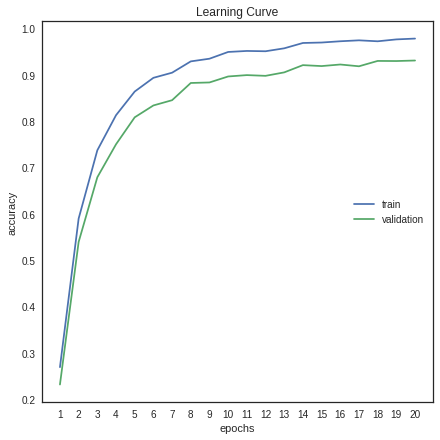

In [43]:
x_train = preprocess(X_train, gray=True, adaeq=True)
x_valid = preprocess(X_valid, gray=True, adaeq=True)
x_test = preprocess(X_test, gray=True, adaeq=True)
train_network(x_train, y_train, epoch=20, learning_rate=.0005, save=True)

Training...

EPOCH 1 ...
Training Accuracy=0.138
Validation Accuracy = 0.140

EPOCH 2 ...
Training Accuracy=0.325
Validation Accuracy = 0.308

EPOCH 3 ...
Training Accuracy=0.460
Validation Accuracy = 0.430

EPOCH 4 ...
Training Accuracy=0.525
Validation Accuracy = 0.478

EPOCH 5 ...
Training Accuracy=0.582
Validation Accuracy = 0.552

EPOCH 6 ...
Training Accuracy=0.646
Validation Accuracy = 0.606

EPOCH 7 ...
Training Accuracy=0.671
Validation Accuracy = 0.636

EPOCH 8 ...
Training Accuracy=0.728
Validation Accuracy = 0.685

EPOCH 9 ...
Training Accuracy=0.752
Validation Accuracy = 0.722

EPOCH 10 ...
Training Accuracy=0.793
Validation Accuracy = 0.763

EPOCH 11 ...
Training Accuracy=0.814
Validation Accuracy = 0.776

EPOCH 12 ...
Training Accuracy=0.832
Validation Accuracy = 0.803

EPOCH 13 ...
Training Accuracy=0.850
Validation Accuracy = 0.813

EPOCH 14 ...
Training Accuracy=0.854
Validation Accuracy = 0.814

EPOCH 15 ...
Training Accuracy=0.866
Validation Accuracy = 0.833

EPOCH 

/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00        30
          1       0.99      0.91      0.95       240
          2       0.75      0.90      0.82       240
          3       0.98      0.67      0.80       150
          4       0.85      0.99      0.91       210
          5       0.59      0.65      0.62       210
          6       0.97      1.00      0.98        60
          7       0.76      0.98      0.85       150
          8       0.99      0.72      0.83       150
          9       0.94      0.97      0.95       150
         10       0.98      1.00      0.99       210
         11       0.89      1.00      0.94       150
         12       0.90      1.00      0.95       210
         13       1.00      1.00      1.00       240
         14       1.00      0.98      0.99        90
         15       0.98      0.99      0.98        90
         16       1.00      0.58      0.74        60
         17       0.98      1.00      0.99   

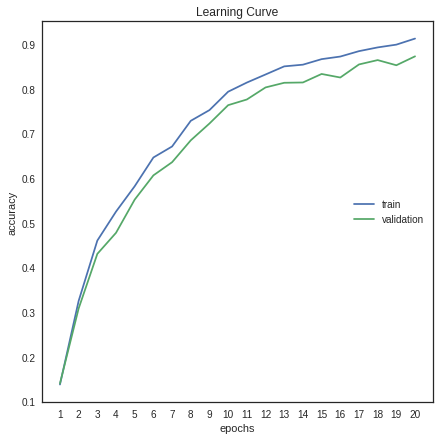

In [37]:
# lenet with 3*3 size kernels. 3 dropout layers
x_train = preprocess(X_train, gray=True, adaeq=True)
x_valid = preprocess(X_valid, gray=True, adaeq=True)
x_test = preprocess(X_test, gray=True, adaeq=True)
train_network(x_train, y_train, epoch=20, learning_rate=.0005, save=True)

Training...

EPOCH 1 ...
Training Accuracy=0.457
Validation Accuracy = 0.404

EPOCH 2 ...
Training Accuracy=0.616
Validation Accuracy = 0.558

EPOCH 3 ...
Training Accuracy=0.733
Validation Accuracy = 0.667

EPOCH 4 ...
Training Accuracy=0.793
Validation Accuracy = 0.726

EPOCH 5 ...
Training Accuracy=0.827
Validation Accuracy = 0.761

             precision    recall  f1-score   support

          0       1.00      0.03      0.06        30
          1       0.77      0.81      0.79       240
          2       0.62      0.68      0.64       240
          3       0.85      0.82      0.84       150
          4       0.78      0.80      0.79       210
          5       0.47      0.43      0.45       210
          6       0.57      0.98      0.72        60
          7       0.94      0.59      0.73       150
          8       0.53      0.87      0.66       150
          9       0.95      0.85      0.90       150
         10       0.89      0.96      0.92       210
         11       0.72   

/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


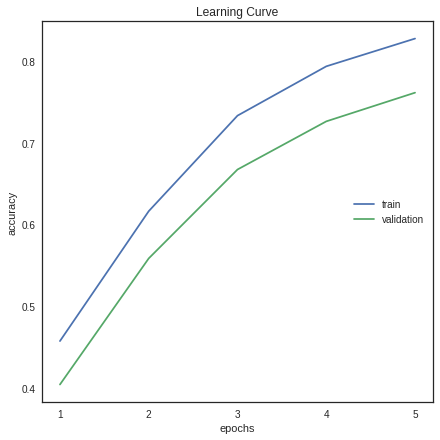

In [26]:
# grayscale only
x_train = preprocess(X_train, gray=True)
x_valid = preprocess(X_valid, gray=True)
x_test = preprocess(X_test, gray=True)
train_network(x_train, y_train, epoch=20)

In [21]:
# test image
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(x_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet


InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [400,120] rhs shape= [576,120]
	 [[Node: save/Assign_4 = Assign[T=DT_FLOAT, _class=["loc:@Variable_4"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](Variable_4, save/RestoreV2_4)]]

Caused by op 'save/Assign_4', defined at:
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-a49f39867c0b>", line 8, in <module>
    saver = tf.train.Saver()
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1056, in __init__
    self.build()
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1086, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 419, in _AddRestoreOps
    assign_ops.append(saveable.restore(tensors, shapes))
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 155, in restore
    self.op.get_shape().is_fully_defined())
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 270, in assign
    validate_shape=validate_shape)
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 47, in assign
    use_locking=use_locking, name=name)
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [400,120] rhs shape= [576,120]
	 [[Node: save/Assign_4 = Assign[T=DT_FLOAT, _class=["loc:@Variable_4"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](Variable_4, save/RestoreV2_4)]]


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

## Preprocessing new images
I collected 5 images from web. The images include watermark, not square, and the position of  
some of the signs are off-center. I added modified version of the images, cropped and painted in crude fashion to increase similiarity to the training set.

### Load and Output the Images

In [19]:
import os
from os import listdir
# load files from path and preprocess
def preprocess_image_path(path):
    image = np.ndarray((len(os.listdir(path)), 32, 32, 3), dtype=float) 
    new_y = []    
    num = len(os.listdir(path))
    plt.figure(figsize=(9, 3*int(np.ceil(num/3))))
    for i, file in enumerate(sorted(os.listdir(path))):
        new_y.append(int(file.split('.')[0]))
        img = cv2.imread(path + file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (32,32), interpolation=cv2.INTER_AREA)
        #img = cv2.copyMakeBorder(img, top=5, bottom=5, left=5, right=5, \
        #                  borderType= cv2.BORDER_CONSTANT, value=[0,0,0] )
        img = cv2.GaussianBlur(img, (3,3), 0)
        
        plt.subplot(np.ceil(num/3), 3, i+1)
        plt.axis('off')        
        plt.imshow(img)        
        image[i] = img
    return preprocess(np.array(image),gray=True, adaeq=True), new_y

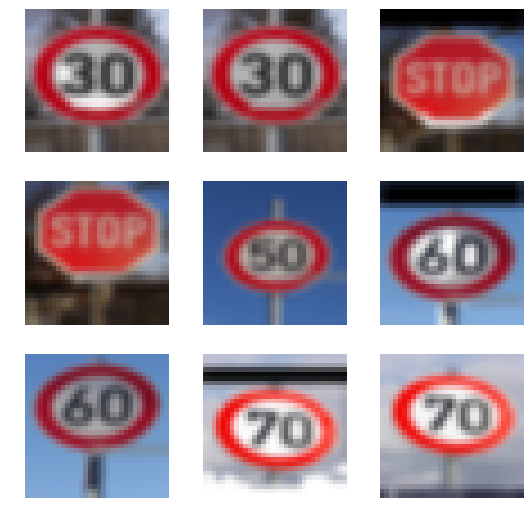

In [20]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
new_image, new_y = preprocess_image_path('./signs/')

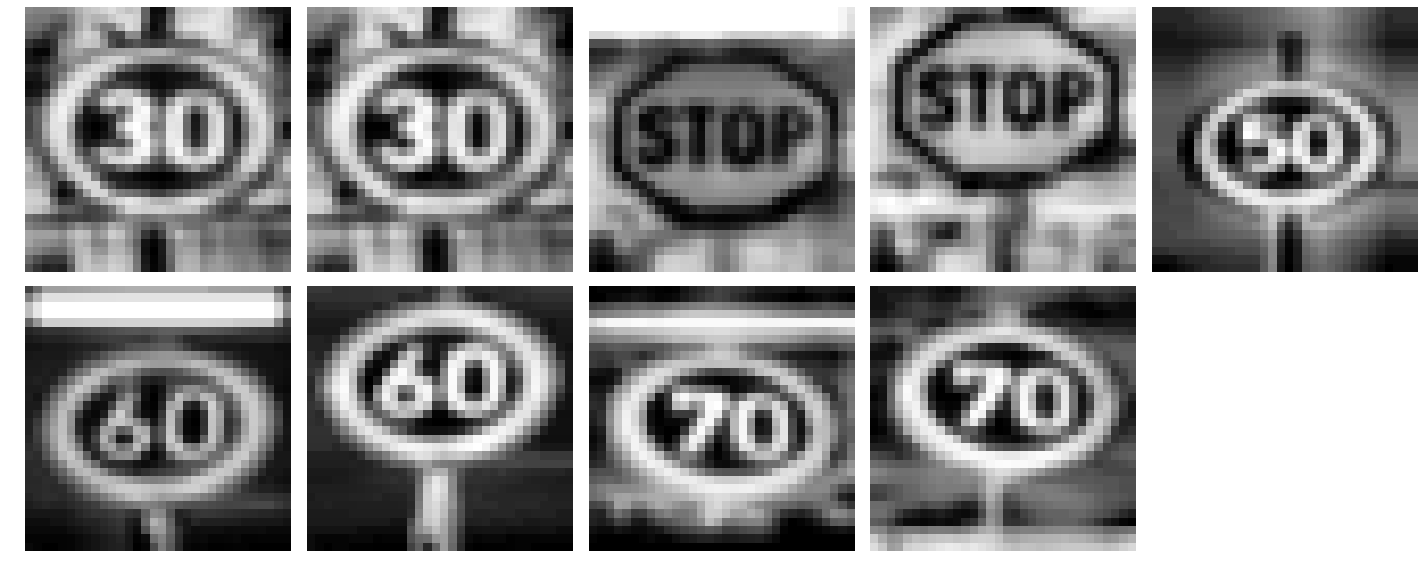

In [21]:
show_all(new_image, 5)

In [22]:
print(new_y)

[1, 1, 14, 14, 2, 3, 3, 4, 4]


### Predict the Sign Type for Each Image

In [26]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
kv2 = None
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './lenet')    
    pred = sess.run(softmax_logits, feed_dict={x: new_image, keep_prob: 1.0})
    kv2 = sess.run(tf.nn.top_k(pred, k=5))
pred_y = np.array([i[0] for i in kv2.indices])
print(pred_y)

INFO:tensorflow:Restoring parameters from ./lenet
[ 1  1 14 12  2  3 12  4 12]


### Analyze Performance

In [27]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
accuracy_score(pred_y, new_y)

0.66666666666666663

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [64]:
sns.set_style("white", {'axes.grid':False})

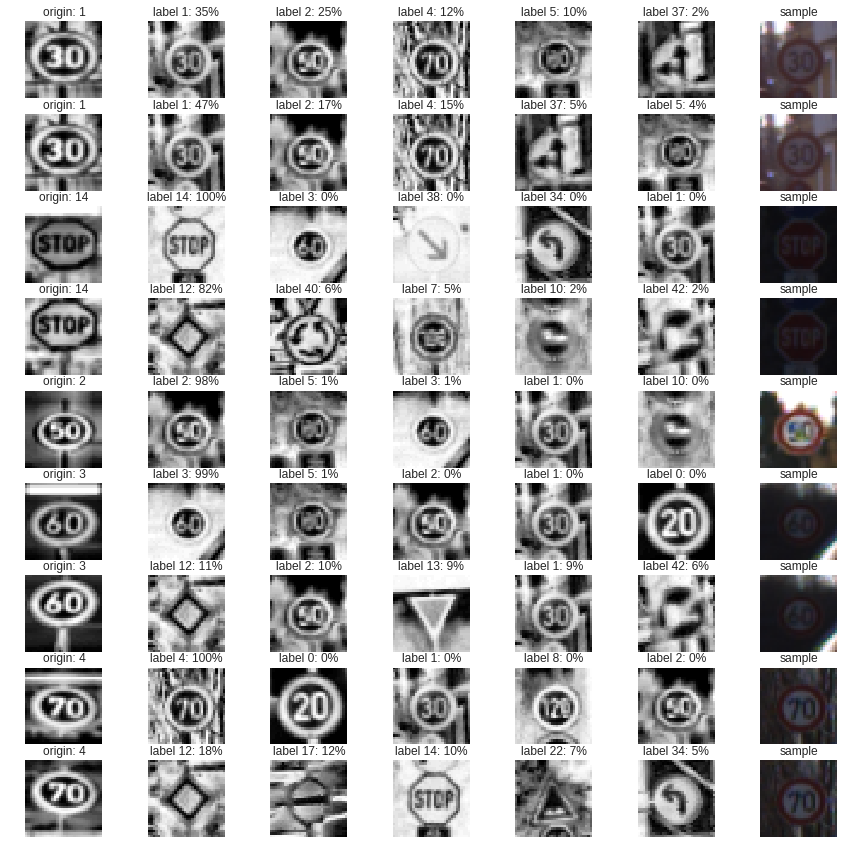

In [28]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
figure = plt.figure(figsize=(15,15))
for i, img in enumerate(new_image):
    row = new_image.shape[0]
    plt.subplot(row, 7, 7*i+1)
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.title('origin: {}'.format(new_y[i]))
    
    index = kv2.indices[i]
    per = kv2.values[i]
    j = 2
    for ind, p in zip(index, per):
        plt.subplot(row, 7, 7*i + j)
        plt.axis('off')
        plt.imshow((x_train[y_train==ind][5].squeeze()))
        plt.title('label {}: {:.0f}%'.format(ind, p*100))        
        j += 1
    
    plt.subplot(row, 7, 7*(i+1))
    plt.axis('off')
    plt.imshow((X_train[y_train==new_y[i]][5].squeeze()))
    plt.title('sample')     
        
#plt.tight_layout()

## The result
After modification, the classifier predicted all 5 samples correctly, where as it predicted only 2 correctly before modification. The position of the sign indeed seems to be a critical feature for the classifier. The training set included augmented samples but would benefit from more extreme translation.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [29]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from ./lenet


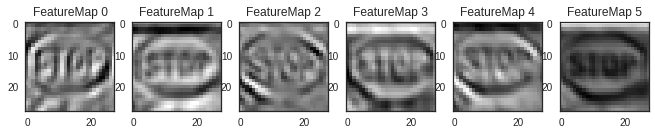

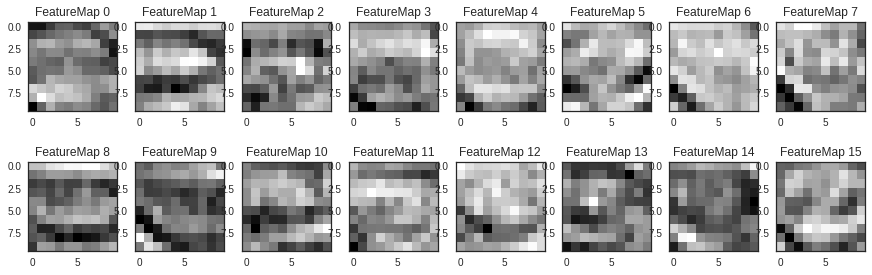

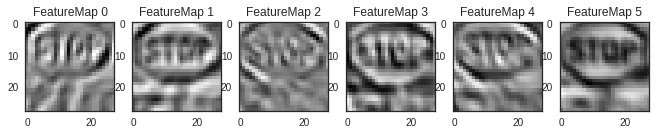

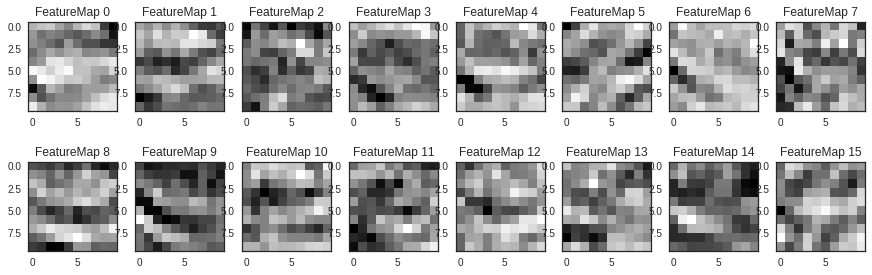

In [52]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './lenet')
    #op = sess.graph.get_operations()
    #[print(m.values()) for m in op][1]
    conv = tf.get_default_graph().get_tensor_by_name('Conv2D:0')
    outputFeatureMap(new_image[2:5], conv, plt_num=1)
    conv = tf.get_default_graph().get_tensor_by_name('Conv2D_1:0')
    outputFeatureMap(new_image[2:5], conv, plt_num=2)
    
    conv = tf.get_default_graph().get_tensor_by_name('Conv2D:0')
    outputFeatureMap(new_image[3:5], conv, plt_num=3)
    conv = tf.get_default_graph().get_tensor_by_name('Conv2D_1:0')
    outputFeatureMap(new_image[3:5], conv, plt_num=4)

# Comparing feature maps
I compared two stop sign images, one of which was classified correctly. The first image is an augmented image of the second one.  
The feature maps of conv1 layer shows similar patterns. However, there seems to be considerable difference in some of conv2 layer features.
